In [1]:
import os
import os.path
import pickle
import bz2
from glob import glob
import random
import time
import shutil
from datetime import datetime
import pathlib
import pandas as pd
import numpy as np
import logging

import tensorflow as tf
import tensorflow.keras as keras
from tqdm.auto import tqdm
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
from kerashypetune import KerasGridSearch

import model as dataModel

In [2]:
logging.basicConfig(filename='app.log', filemode='w', format='%(asctime)s - %(name)s - %(message)s',level=logging.DEBUG)

pd.set_option("display.max_columns", None)

In [3]:
days_of_history = 30
days_to_predict = 7

In [5]:
df = dataModel.load_dataset('./golden_df.pkl')


In [6]:
dataModel.prepare_data(df, days_of_history=30, days_to_predict=7)

0.100.200.300.400.500.600.700.800.900.1000.1100.1200.1300.1400.1500.1600.1700.1800.1900.2000.2100.2200.2300.2400.2500.2600.2700.2800.2900.3000.

In [7]:
dataModel.train_test_eval_split()

In [4]:
train_ds, val_ds, test_ds = dataModel.get_train_test_eval_ds(days_to_predict=7)

In [14]:
test = np.load("./data/eval/x_10.npy")
test.shape

(199, 37, 100)

In [18]:
# HP_LAYER_TYPE=hp.HParam('layer_type', hp.Discrete(['keras.layers.LSTM', 'keras.layers.GRU']))
HP_LAYER_TYPE=hp.HParam('layer_type', hp.Discrete(['keras.layers.LSTM']))
HP_N_RECURRENT=hp.HParam('n_recurrent', hp.Discrete([1,2]))
# HP_N_UNIT=hp.HParam('n_unit', hp.Discrete([32, 64, 128]))
HP_N_UNIT=hp.HParam('n_unit', hp.Discrete([64, 128, 256]))
HP_DROPOUT=hp.HParam('dropout', hp.Discrete([0.20]))
HP_LR=hp.HParam('lr', hp.Discrete([1e-3]))
METRIC_MAE = 'mae'
# HP_L2=
EPOCHS=10


with tf.summary.create_file_writer('logs/wide_search').as_default():
    hp.hparams_config(
    hparams=[HP_LAYER_TYPE, HP_N_RECURRENT, HP_N_UNIT, HP_DROPOUT, HP_LR],
    metrics=[hp.Metric(METRIC_MAE, display_name='Mean Avg Error')],
  )

In [19]:


def train_test_model(hparams, shape=(37,100), OUT_STEPS=7):
    dataModel.set_seed()
    input = keras.layers.Input(shape=shape)
    last = input
    for i in range(hparams[HP_N_RECURRENT]):
        if i < hparams[HP_N_RECURRENT] - 1:
            last = eval(hparams[HP_LAYER_TYPE])(hparams[HP_N_UNIT], return_sequences=True)(last)
        else:
            last = eval(hparams[HP_LAYER_TYPE])(hparams[HP_N_UNIT])(last)
        
        if hparams[HP_DROPOUT]:
            last = keras.layers.Dropout(hparams[HP_DROPOUT])(last)
    if OUT_STEPS == 7:
        last = keras.layers.Dense(OUT_STEPS*1)(last)
        output = keras.layers.Reshape([OUT_STEPS, 1])(last)
    else:
        output = keras.layers.Dense(1)(last)
    
    model = keras.models.Model(inputs=input, outputs=output)
    
    model.compile(optimizer = Adam(learning_rate=hparams[HP_LR]),
                  loss='mae'
                 ) 
    print(model.summary())
    model.fit(train_ds,
            validation_data=val_ds,
            epochs=EPOCHS)
 
    val_loss = model.evaluate(test_ds)
    return val_loss

def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        val_loss = train_test_model(hparams)
        tf.summary.scalar(METRIC_MAE, val_loss, step=1)

In [20]:
session_num = 0
for layer_type in HP_LAYER_TYPE.domain.values:
    for n_recurrent in HP_N_RECURRENT.domain.values:
        for n_unit in HP_N_UNIT.domain.values:
            for dropout in HP_DROPOUT.domain.values:
                for lr in HP_LR.domain.values:
                    hparams = {
                      HP_LAYER_TYPE: layer_type,
                      HP_N_RECURRENT: n_recurrent,
                      HP_N_UNIT: n_unit,
                      HP_DROPOUT: dropout,
                      HP_LR: lr
                    }
                    run_name = f'run-{session_num}-layers-{n_recurrent}-nodes-{n_unit}'
                    print(f'--- Starting trial: {run_name}')
                    print({h.name: hparams[h] for h in hparams})
                    run(f'./logs/wide_search/{run_name}', hparams)
                    session_num += 1

--- Starting trial: run-0-layers-1-nodes-64
{'layer_type': 'keras.layers.LSTM', 'n_recurrent': 1, 'n_unit': 64, 'dropout': 0.2, 'lr': 0.001}
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 37, 101)]         0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                42496     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 455       
                                                                 
 reshape_2 (Reshape)         (None, 7, 1)              0         
                                                                 
Total params: 42,951
Trainable params: 42,951
Non-

In [5]:
# Changing the model to predict 7 days ahead
OUT_STEPS = days_to_predict
number_of_features = 100
input = keras.layers.Input(shape=(30,100))
lstm1 = keras.layers.LSTM(256, return_sequences=True)(input)
dropout1 = keras.layers.Dropout(0.20)(lstm1)
lstm2 = keras.layers.LSTM(256, return_sequences=True)(dropout1)
dropout2 = keras.layers.Dropout(0.20)(lstm2)
lstm3 = keras.layers.LSTM(256, return_sequences=False)(dropout2)
dropout3 = keras.layers.Dropout(0.20)(lstm3)

dense = keras.layers.Dense(OUT_STEPS*1)(dropout3)
output = keras.layers.Reshape([OUT_STEPS, 1])(dense)

model = keras.models.Model(inputs=input, outputs=output)



In [6]:
NAME = 'lr_tests_correct_input_shape_3_layer_256nodes'

In [15]:
1e-3 * 10 ** ((1) / 30),1e-3 * 10 ** ((60) / 30)

(0.0010797751623277097, 0.1)

In [16]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(f'./data/model/{NAME}.h5', save_best_only=True)
# early_stopping_cb = keras.callbacks.EarlyStopping(monitor='mse', min_delta= 1e-8, patience=10, restore_best_weights=True)
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** ((epoch) / 30))
tensorboard = keras.callbacks.TensorBoard(log_dir="logs/predict_7/{}".format(NAME))

In [17]:
model.compile(optimizer = Adam(),  loss='mae',  metrics=['mse'])

In [12]:
# model = keras.models.load_model("./data/model/correct_input_shape_3_layer_256nodes.h5")

In [18]:
history = model.fit(train_ds, epochs=60, 
                    validation_data=val_ds, 
                    callbacks=[tensorboard, checkpoint_cb, lr_callback]
                   )

Epoch 1/60
1188/1188 [==============================] - 138s 113ms/step - loss: 5995.0439 - mse: 1014384256.0000 - val_loss: 6007.3789 - val_mse: 1125590272.0000 - lr: 0.0010
Epoch 2/60
1188/1188 [==============================] - 137s 115ms/step - loss: 5845.7378 - mse: 1010337664.0000 - val_loss: 5872.8838 - val_mse: 1119218176.0000 - lr: 0.0011
Epoch 3/60
1188/1188 [==============================] - 138s 115ms/step - loss: 5754.4546 - mse: 1006476416.0000 - val_loss: 5828.5859 - val_mse: 1117772160.0000 - lr: 0.0012
Epoch 4/60
1188/1188 [==============================] - 138s 115ms/step - loss: 5699.1064 - mse: 1004710016.0000 - val_loss: 5733.2446 - val_mse: 1114909440.0000 - lr: 0.0013
Epoch 5/60
1188/1188 [==============================] - 138s 115ms/step - loss: 5647.2402 - mse: 1002527360.0000 - val_loss: 5721.9087 - val_mse: 1113908992.0000 - lr: 0.0014
Epoch 6/60
1188/1188 [==============================] - 137s 115ms/step - loss: 5617.7139 - mse: 1001236864.0000 - val_loss: 

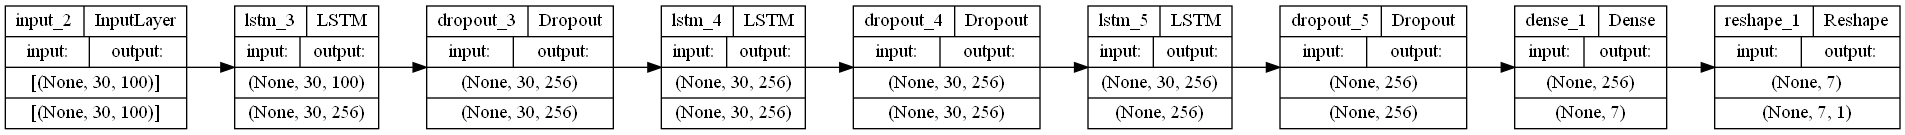

In [29]:
keras.utils.plot_model(model, to_file="7_day_mse.png", show_shapes=True, show_dtype=False, 
                       show_layer_activations=False, rankdir='LR')

In [19]:
model.save(f'data/model/redone_lr_tests_{NAME}')
# data/model/mse_trained_RMSE_loss_correct_input_shape_3_layer_256nodes.h5

INFO:tensorflow:Assets written to: data/model/redone_lr_tests_lr_tests_correct_input_shape_3_layer_256nodes\assets


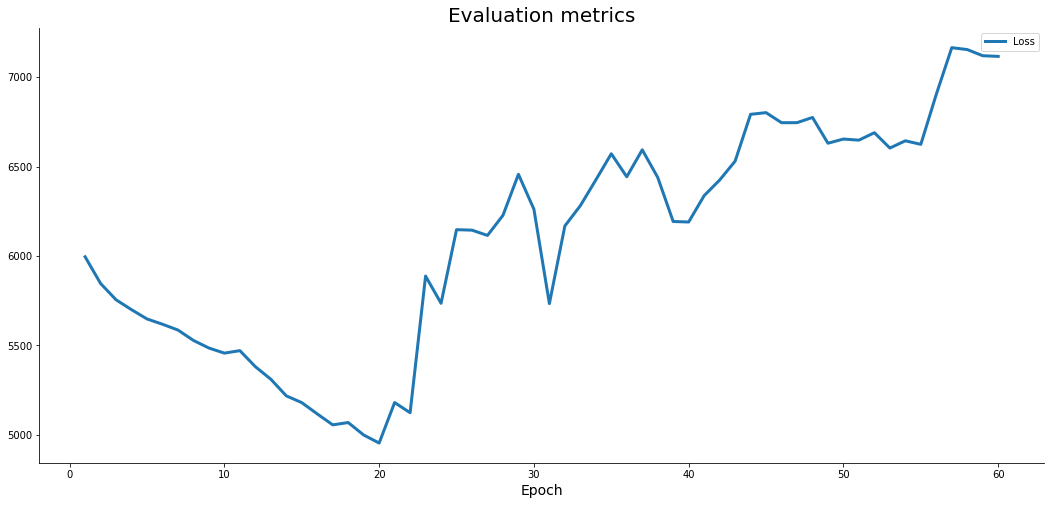

In [21]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (18, 8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False 

plt.plot(
    np.arange(1, 61), 
    history.history['loss'], 
    label='Loss', lw=3
)
# plt.plot(
#     np.arange(1, 22), 
#     history.history['root_mean_squared_error'], 
#     label='root_mean_squared_error', lw=3
# )
# plt.plot(
#     np.arange(1, 61), 
#     history.history['lr'], 
#     label='Learning rate', color='#000', lw=3, linestyle='--'
# )

plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

In [21]:
history.history.keys()

dict_keys(['loss', 'mse', 'mae', 'root_mean_squared_error', 'val_loss', 'val_mse', 'val_mae', 'val_root_mean_squared_error', 'lr'])

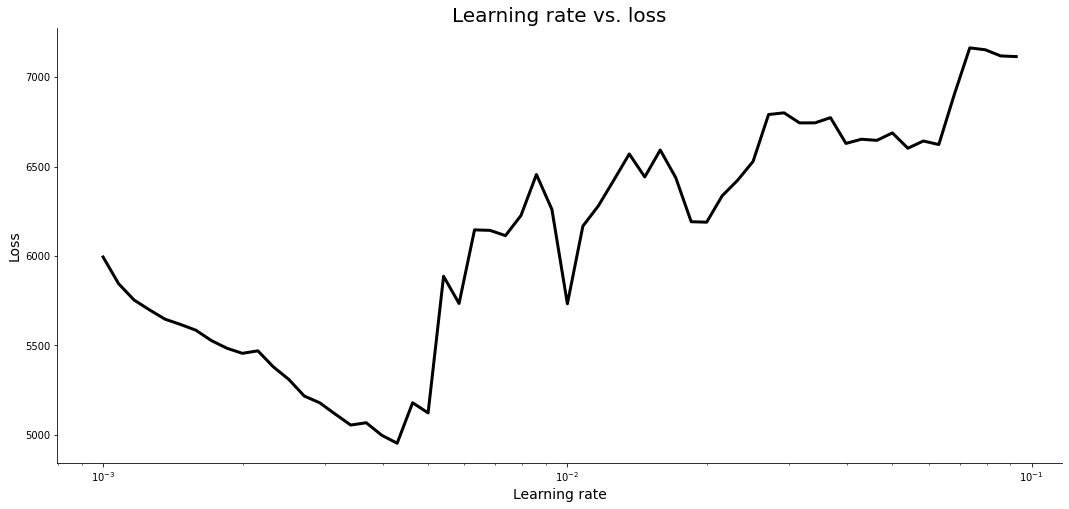

In [23]:
learning_rates = 1e-3 * (10 ** (np.arange(60) / 30))
plt.semilogx(
    learning_rates, 
    
    history.history['loss'], 
    lw=3, color='#000'
)
# plt.xticks(np.arange(min(learning_rates), max(learning_rates),0.001),rotation=30)
# plt.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14);

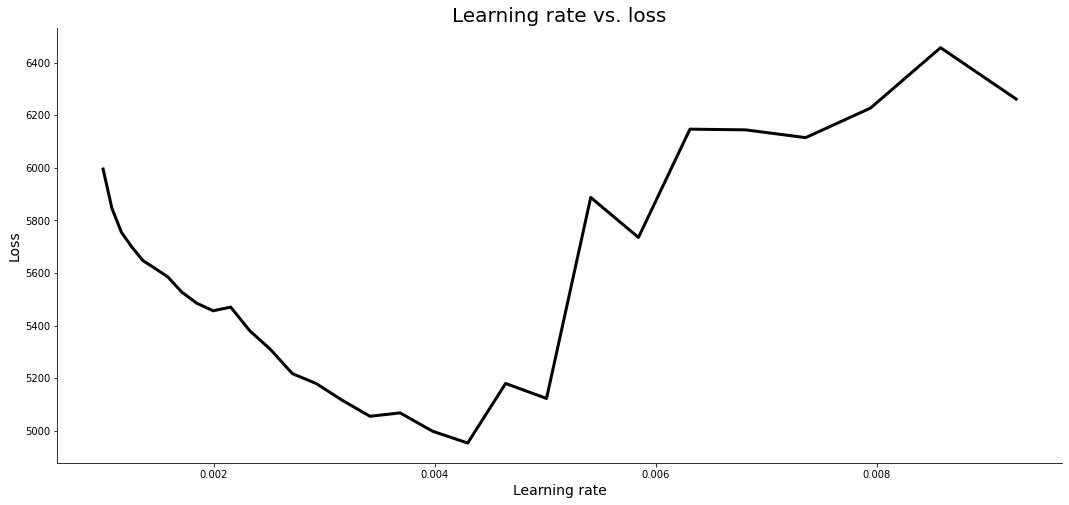

In [28]:
learning_rates = 1e-3 * (10 ** (np.arange(30) / 30))
plt.plot(
    learning_rates, 
    
    history.history['loss'][:30], 
    lw=3, color='#000'
)
# plt.xticks(np.arange(min(learning_rates), max(learning_rates),0.001),rotation=30)
# plt.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14);
plt.savefig('./eval_plots/learing_rate_v_loss.png')